<a href="https://colab.research.google.com/github/ricco-hub/ztf_summer_school_2024/blob/main/Copy_of_BBH_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Production ML Pipeline For Gravitational Wave Detection

All modified from a [demo](https://github.com/alecgunny/adass-2023-ml4gw-demo/tree/main) made by Alec Gunny



Steps:


1. Make a copy of this notebook: File → "Save a copy in Drive"  
2. Connect to GPU runtime: Runtime → "Change runtime type" → "T4 GPU"
  - I'm not totally sure what Colab's limits on GPU usage are, but it might be a good idea to have only one member of your group connect to a GPU runtime, while the rest stay on CPU. Most of this notebook can be run without a GPU, and if one person runs out of GPU credits, another can swap in
3. Mount Google Drive with code block below. You'll need to grant Google Drive some permissions for this to work



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4. Open up the file explorer in the left sidebar (using the folder icon) and locate the zip file in your Drive. In the cell below, replace the path with the path to your file, and run the cell to unzip it.

In [2]:
%%capture
# Fill in the path to your copy of the zip file
# Should take ~1 minute. The %%capture is there to suppress output
!unzip drive/MyDrive/2023-2024/Spring\ 2024/ZTF_Aframe_lesson.zip

In [ ]:
# Fixes a bug that comes up sometimes
# If you get an error involving a "UTF-8 encoding", uncomment and run the below

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

5. Finally, run the cell below to do a little organization and clean-up

In [3]:
# For convenience, move everything into the top-level, and remove a file
# that osx puts in zips
!mv ZTF_Aframe_lesson/* /content/
!rm -r __MACOSX

At this point, you should be good to run the rest of the notebook!

## Machine Learning in Gravitational Wave Astrophysics
- Writing ML training code is (relatively) easy: `model.fit(X, y)`
- Doing good _science_ with ML is hard
    - Largest gains from development of domain specific ecosystems
    - Fast tools with intuitive APIs that map on to familiar concepts
- GW physics has a great software ecosystem
    - Robust simulations, good priors, etc., but none optimized for ML

This tutorial has three goals:
1. Introduce the typical data you encounter when doing GW astrophysics, and the typical processing/analysis steps that you perform on the data
2. Demonstrate a straightforward way someone might think to use machine learning to address the problem binary black hole detection, and highlight the ways that this approach fails
3. Show how good software infrastructure and use of physical knowledge can improve performance

We'll start with some installations and a couple of imports:

In [30]:
%%capture
# Install libraries that aren't installed by default. Takes a couple of minutes
!pip install bilby gwpy lightning ml4gw pycbc torchtyping tritonclient utils matplotlib

In [34]:
# Take care of a couple imports and variable definitions up top
import h5py
import numpy as np
from matplotlib import pyplot as plt
from utils import plotting

# These are the detectors we'll be using: Hanford and Livingston
ifos = ["H1", "L1"]
# And this is the sample rate that all of our data will be at
sample_rate = 2048

## Let's take a look at the data we're dealing with and typical processing steps

Side note: you may have noticed the `data.ipynb` notebook. This is the notebook I used to generate most of the data. We won't be using it here, but feel free to poke around if you're curious. Something to note for reference is that even generating a relatively small amount of data using the typical software stack took ~45 minutes. There's more that could have been done to optimize the process, but still: scaling up data is non-trivial.

#### What's in our data directory?

In [6]:
!ls data

background.hdf5  cache.hdf5  signals.hdf5


### `background.hdf5`

In [7]:
with h5py.File("data/background.hdf5", "r") as f:
    for split in ["train", "valid", "test"]:
        num_segments = len(f[split])
        duration = sum([len(v[ifos[0]]) / sample_rate for v in f[split].values()])
        print(
            "{} segments in {} split, corresponding to {:0.2f} h of livetime".format(
                num_segments, split, duration / 3600
            )
        )

5 segments in train split, corresponding to 7.59 h of livetime
2 segments in valid split, corresponding to 3.27 h of livetime
5 segments in test split, corresponding to 8.17 h of livetime


Real, open data observed by the Hanford (H1) and Livingston (L1) interferometers starting on April 1st 2019
- About 11 hours for training/validation, and 8 hours for testing

What does that mean in terms of file size?

In [8]:
!du -sh data/background.hdf5

2.1G	data/background.hdf5


When we train a model for real, we use multiple weeks, if not months, of background data. The more different instances of data, the better! But that takes up 10s or 100s of GB and would make running this notebook take forever, so we'll stick with the smaller dataset and live with the worse performance.

### What does this data look like?

In [11]:
# Feel free to change the length to get a sense of what the data is like
# over e.g., 1 second, 10 seconds, a minute

length = 10 # units of seconds
num_datapoints = int(sample_rate * length)

with h5py.File("data/background.hdf5", "r") as f:
    dataset = f["train"]["1238175433-17136"]  # start timestamp of segment-duration
    background = {i: dataset[i][:num_datapoints] for i in ifos}
t = np.arange(num_datapoints) / sample_rate

# Note: the axis labels sometimes fail to render on the first execution.
# If that happens, just run the cell again
plotting.plot_timeseries(t, **background)

Looks like a lot of random noise - which it is. The stretch of data that we're using for background doesn't contain any known events.

Note the typical order of magnitude of the background strain: around $10^{-19}$

One quick note on plotting: there are a number of plotting functions that have been defined in `utils/plotting.py` that I use to plot examples in this notebook in the way that I want. Don't let that stop you from importing `matplotlib` and plotting things your own way! The only purpose of the `plotting` file is to hide away a lot of the formatting stuff that would get in the way otherwise.

### `signals.hdf5`

Simulated waveforms generated by gravitational wave events along with the parameters of those events
- Train and validation datasets contain raw waveform **polarizations**

In [12]:
with h5py.File("data/signals.hdf5") as f:
    for split in ["train", "valid"]:
        dataset = f[split]["polarizations"]["cross"]
        num_signals, size = dataset.shape
        print("{} {} s signals in {} split".format(len(dataset), size/sample_rate, split))

2500 4.0 s signals in train split
500 4.0 s signals in valid split


With a file size of:

In [13]:
!du -sh data/signals.hdf5

646M	data/signals.hdf5


Again, we typically use 40 times more data than this: 100,000 waveforms for training, and 20,000 for validation. Simply increasing the diversity of data that your network is exposed to is often a good way to improve performance.

With the amount of data we're using here, the models will be able to learn _something_, but they won't be all that sensitive.

And what do these signals look like? Let's look at the loudest training signal. Signal loudness is characterized
by the signal-to-noise ratio, or SNR. The loudest signal in this dataset has an SNR of about 117 relative to the background noise in the training set.

In [14]:
with h5py.File("data/signals.hdf5") as f:
    split = f["train"]
    idx = split["parameters"]["snr"][:].argmax()
    # To see what a random waveform looks like, uncomment the line below
    # idx = np.random.randint(len(split["polarizations"]["cross"]))
    signal = {i: split["polarizations"][i][idx] for i in ["cross", "plus"]}
t = np.arange(size) / sample_rate
plotting.plot_timeseries(t, **signal)

As they should be, the `cross` and `plus` polarizations of the wave are out of phase by $\pi/2$. Note that the waveform peaks on the order of $10^{-21}$

## Interlude: Testing out waveform parameters

Let's take a break from building towards a machine learning model in order to explore how different parameters affect the form of gravitational waves from binary black holes. Begin by defining some waveform parameters:

In [15]:
params = {
    "approximant" : "IMRPhenomPv2",
    "mass1" : 30,
    "mass2" : 30,
    "spin1x" : 0.,
    "spin1y" : 0.,
    "spin1z" : 0.,
    "spin2x" : 0.,
    "spin2y" : 0.,
    "spin2z" : 0.,
    "distance" : 100.,
    "inclination" : 0.,
    "delta_t" : 1.0 / sample_rate,
    "f_lower" : 20,
}

Here's what each of these parameters means:

- Approximant: the numerical relativity model used to simulate the waveform. I won't go into the details here, but this approximant covers three different phases of the signal: Inspiral, which is the smooth evolution prior to coalescence; Merger, which is the behavior of the signal close to and at coalescence time; and Ringdown, which is after the system has merged.
- Mass 1, 2: The mass of each object in units of solar masses. These parameters have the most pronounced effect on the waveform, so they're good to play around with. I would keep these values in the [1, 100] range.
- Spin 1i, 2i: The cartesian components of the dimensionless spin angular momentum of each object. These parameters can take values in (-1, 1). The effect is more subtle here, but still noticeable. For the `IMRPhenomPv2` approximant, the spins are allowed to be _misaligned_, meaning that they don't need to point in the same direction. Misaligned spins cause the system to precess (the "P" of `IMRPhenomPv2`).
- Distance: The luminosity distance to the system units of megaparsecs. The distance affects the amplitude of the waveform, and you can make it more or less whatever you want, though a reasonable range is (0, 1000] or so.
- Inclination: The angle between the orbital angular momentum of the system and the line of sight to the system in radians. Takes values in the range [0, $\pi$), after which the effect is periodic. This also has a fairly significant effect on the polarizations.
- delta_t: The gap in time between each point, which I'm just setting to the inverse of the sample rate we defined up at the top. No need to mess with this one.
- f_lower: The frequency of the system at the point that the simulation begins. Not all that useful to change this one either.



#### Next, I'll define a couple functions to make waveform generation a little more seamless

In [16]:
from pycbc.waveform import get_td_waveform
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u

# Helper function to put parameters into the reference frame that
# PyCBC is expecting
def convert_to_detector_frame(**params):
    converted = {}
    distance = params["distance"] * u.Mpc
    redshift = z_at_value(Planck15.luminosity_distance, distance).value
    for k, v in params.items():
        if k.startswith("mass"):
            converted[k] = v * (1 + redshift)
        else:
            converted[k] = v
    return converted

# Convenience function for getting the waveforms and cropping
# to the size we want. You may want to increase max_length
# for longer signals, or decrease it for short ones
def generate_waveform(max_length: float = 4, **params):
  hp, hc = get_td_waveform(**params)

  # IMRPhenomPv2 includes a bunch of extra time
  # after the ringdown that we don't want
  mask = hp.sample_times.data < 0.05
  hp, hc = hp[mask], hc[mask]

  max_size = min(max_length * sample_rate, len(hp))
  hp, hc = hp[-max_size:], hc[-max_size:]
  polarizations =  {"cross": hc, "plus": hp}

  t = np.arange(max_size) / sample_rate

  return t, polarizations

#### Using the code block below, play around with the different parameters, and try to understand the different effects of each

In [19]:
# For convenience, I'll redefine the parameter dict down here,
# so we don't have to scroll back and forth so much
params = {
    "approximant" : "IMRPhenomPv2",
    "mass1" : 45,
    "mass2" : 30,
    "spin1x" : 0.5,
    "spin1y" : 0.,
    "spin1z" : 0.,
    "spin2x" : 0.,
    "spin2y" : 0.,
    "spin2z" : 0.,
    "distance" : 100.,
    "inclination" : 0.,
    "delta_t" : 1.0 / sample_rate,
    "f_lower" : 20,
}

params = convert_to_detector_frame(**params)
t, polarizations = generate_waveform(**params)
plotting.plot_timeseries(t, **polarizations)

### Going from polarizations to detector responses

So these plots show us what the _polarizations_ of the signal look like. And if the plane of a detector were perpendular to the direction of travel of the wave, and the arms of the detector were aligned with the direction of the polarizations, then this is what we'd see in the detectors, too (plus noise).

But the Earth rotates, and revolves around the sun, and signals come from multiple locations on the sky, and each has its own polarization angle. To get the detector response, we need to take each polarization, and _project_ it onto each interferometer.

- Inteferometers act as antennae that respond linearly to polarizations
- Function of relative locations/orientations of detectors and source

<img src="https://github.com/alecgunny/adass-2023-ml4gw-demo/blob/main/images/orientations.png?raw=true" width=50% style="display: block;margin-left:auto;margin-right:auto"></img>

In principle, this is a complicated thing to think about: the response is a function of the relative position between the source and the detector. Fortunately, people have solved this problem and created nice functions to do this projection for us.

In [20]:
from pycbc.detector import Detector

# Declination and right ascension are the position on the sky,
# while polarization is the angle of the signal's polarization
sky_params = ["declination", "right_ascension", "polarization"]
with h5py.File("data/signals.hdf5", "r") as f:
    split = f["train"]
    # Again looking at the loudest signal
    idx = split["parameters"]["snr"][:].argmax()
    signal = {i: split["polarizations"][i][idx] for i in ["cross", "plus"]}
    params = {i: split[f"parameters/{i}"][idx] for i in sky_params}

responses = {}
for ifo in ifos:
    detector = Detector(ifo)
    # Note that the position of the detector is encoded in the GPS time of
    # the event. If you change the GPS time by some significant number of
    # seconds (> ~10,000), you'll notice a (subtle) change in the response
    fp, fc = detector.antenna_pattern(t_gps=1238185433, **params)
    response = ht = fp * signal["plus"] + fc * signal["cross"]
    responses[ifo] = ht
plotting.plot_timeseries(t, **responses)

- Projection from polarization → response introduces:
    - phase shifts due to differences in arrival times
    - differences in relative amplitudes due to slight differences in polarization
- The testing signals have been pre-projected so that we can analyze them as if they're real events
- All signals have been rejection sampled to ensure their **signal-to-noise ratio** (SNR) is $\geq$ 4 (see below)

### Exercise: Waveform Parameter Histograms

It's always good to understand the data you're using to train a model. The signals used for training and testing were all simulated in the same way:

1. Define probability distributions over each parameter needed to simulate a signal
2. Sample parameters from each distribution and use them to generate a waveform
3. Measure the SNR of the signal relative to the relevant background (training background for training signals, etc.)
4. If the SNR is $\geq$ 4, keep the signal. Otherwise, discard it and try again.

The parameters of the accepted signals are stored in the `signals.hdf5` file, and the original probability distributions are defined in the cell below:

In [21]:
from astropy.cosmology import Planck15
from bilby.core.prior import (
    ConditionalPowerLaw,
    ConditionalPriorDict,
    Cosine,
    PowerLaw,
    Sine,
    Uniform
)
from bilby.gw.prior import UniformComovingVolume


def mass_condition_powerlaw(reference_params, mass1):
    """
    Return a dictionary that can be interpreted by Bilby's
    `ConditionalPowerLaw` to set the maximum value of `mass2`
    to be whatever was drawn for `mass1`
    """
    return dict(
        alpha=reference_params["alpha"],
        minimum=reference_params["minimum"],
        maximum=mass1,
    )

msun = r"$M_{\odot}$"
prior = ConditionalPriorDict()
prior["mass1"] = PowerLaw(alpha=-2.35, minimum=5, maximum=100, unit=msun)
prior["mass2"] = ConditionalPowerLaw(
    condition_func=mass_condition_powerlaw,
    alpha=1,
    minimum=5,
    maximum=100,
    unit=msun,
)
prior["redshift"] = UniformComovingVolume(0, 0.2, name="redshift", cosmology=Planck15)
prior["spin1_mag"] = Uniform(0, 0.998)
prior["spin2_mag"] = Uniform(0, 0.998)
prior["spin1_tilt"] = Sine(unit="rad")
prior["spin2_tilt"] = Sine(unit="rad")
prior["spin1_azimuth"] = Uniform(0, 2 * np.pi)
prior["spin2_azimuth"] = Uniform(0, 2 * np.pi)
prior["inclination"] = Sine(unit="rad")

prior["declination"] = Cosine()
prior["right_ascension"] = Uniform(0, 2 * np.pi)
prior["polarization"] = Uniform(0, np.pi)

def sample_params(num_samples):
    params = prior.sample(num_samples)
    spherical = ["mag", "tilt", "azimuth"]
    for i in range(2):
        mag, tilt, azi = [params.pop(f"spin{i+1}_{j}") for j in spherical]
        params[f"spin{i+1}_x"] = mag * np.sin(tilt) * np.cos(azi)
        params[f"spin{i+1}_y"] = mag * np.sin(tilt) * np.sin(azi)
        params[f"spin{i+1}_z"] = mag * np.cos(tilt)
    return params


Use the `sample_params` function to sample parameters from the original distributions, and make histograms comparing these to the parameters of waveforms that passed the rejection sampling. Do the differences/similarities make sense, given your experimentation with waveform generation?

Keys from signals.hdf5: ['test', 'train', 'valid']
Keys in valid: ['declination', 'inclination', 'mass1', 'mass2', 'polarization', 'redshift', 'right_ascension', 'snr', 'spin1_x', 'spin1_y', 'spin1_z', 'spin2_x', 'spin2_y', 'spin2_z']


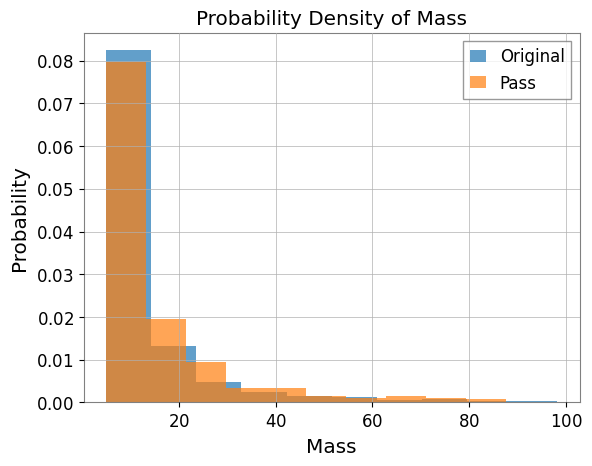

In [76]:
mass_1_original = sample_params(10000)['mass1']

with h5py.File("data/signals.hdf5") as f:
  print('Keys from signals.hdf5:', list(f.keys()))
  dataset = f['valid']
  params = list(dataset['parameters'])
  print('Keys in valid:', params)

with h5py.File("data/signals.hdf5") as f:
  mass_1_pass = f['valid']['parameters']['mass1']
  mass_1_pass = np.array(mass_1_pass)

plt.xlabel('Mass')
plt.ylabel('Probability')
plt.title('Probability Density of Mass')
plt.hist(mass_1_original, label='Original', density=True, alpha=0.7);
plt.hist(mass_1_pass, label='Pass', density=True, alpha=0.7);
plt.legend()
plt.show()

## Back to detection
What examples can we give a neural network that will help it learn to detect presence of signal?
- "Loudest" part of signal is in last 0.5-1 seconds, near the **coalescence**
- Signals add simply to background noise, i.e. $h(t) = n(t) + s(t)$
- So why don't we:
    - Take short windows of background, say 1s
    - Add simulated/projected signals to ~50% of them
    - Train a binary classification network on this data

What would this data look like? What does the network "see"?

In [73]:
injected, uninjected = {}, {}
for ifo in ifos:
    # Take a second of background
    bg = background[ifo][-sample_rate:]
    uninjected[ifo] = bg
    injected[ifo] = bg.copy()
    # And add into it the last second of the waveform
    injected[ifo] += responses[ifo][-sample_rate:]
t = np.arange(len(bg)) / sample_rate
titles = ["Before injection", "After injection"]
plotting.plot_side_by_side(uninjected, injected, t, titles=titles)

No major difference - but this shouldn't be suprising:  background strain is $O(10^{-19})$, while waveforms are $O(10^{-21})$ at best

Well we tried

Thank you for coming.

Okay, but actually, how have we been able to detect gravitational waves if this is what we're dealing with? Well:
- Most of background is low frequency content - 10-30Hz
- Most of signal is in 10-500Hz (in general)
- Emphasize signal by **whitening** the data: normalize frequency content by amplitude spectral density (ASD) of background

In [74]:
from gwpy.timeseries import TimeSeries

asd_length, fftlength = 8, 2
asds = {}
psds = {}
for ifo in ifos:
    bg = TimeSeries(background[ifo], sample_rate=sample_rate)
    asds[ifo] = bg.crop(0, asd_length).asd(fftlength, method="median")
    # The power spectral density (PSD) is the square of the ASD
    psds[ifo] = asds[ifo] ** 2
plotting.plot_spectral(**psds)

The PSD represents the amount of signal power at each frequency. When we whiten the noise+signal, we're normalizing the sample's power in each frequency bin. Because the noise and the signal have power at different frequencies, the background gets muffled and the signal gets amplified.

In [77]:
injected, uninjected = {}, {}
for ifo in ifos:
    # This time, I'm going to grab 2 seconds for reasons that will become clear
    bg = background[ifo][-2 * sample_rate:]
    uninjected[ifo] = bg
    injected[ifo] = bg.copy()
    injected[ifo][:sample_rate] += responses[ifo][-sample_rate:]

for ifo in ifos:
    for src in [injected, uninjected]:
        x = TimeSeries(src[ifo], sample_rate=sample_rate)
        # GWpy has a nice, built-in whitening function, so we'll use that
        x = x.whiten(asd=asds[ifo], fduration=1)
        # As is common when applying filters, the edges of the sample get
        # corrupted, and so need to be cropped out. This is why I grabbed
        # two seconds earlier
        x = x.crop(0.5, 1.5)
        src[ifo] = x.value
t = np.arange(len(bg)) / sample_rate
t = t[sample_rate // 2: -sample_rate // 2]
titles = ["Before injection", "After injection"]
plotting.plot_side_by_side(uninjected, injected, t, titles=titles)

After whitening, the signal is visible by eye! That's a good sign for being able to detect these things with machine learning.

So a quick flowchart of how we'll generate the samples on which to train our neural network:


<img src="https://github.com/alecgunny/adass-2023-ml4gw-demo/blob/main/images/sample-flow.png?raw=true" width=50% style="display: block;margin-left:auto;margin-right:auto"></img>

## Training the network

How do we do this in practice?
- Too much background to fit in memory at once
- Not sure if we can do it in real-time
- Start by generating fixed train and validation datasets up front based on the flowchart above, then fit on these

- The `make_dataset` function takes care of these steps using the traditional GW software stack
- I was planning on having you run this yourselves, but it ended up being too slow of a process on Colab, so I created the data file ahead of time. If you're curious, check out the `make_dataset` function in `utils/data.py`.
- On a more favorable system it took about 6 minutes to run, which isn't bad, but remember that we'd really like to be using ~50-100 times more data, so this would get pretty time-consuming if we were to do it this way for real

In [78]:
# from utils.data import make_dataset

# background_f = h5py.File("data/background.hdf5")
# signal_f = h5py.File("data/signals.hdf5")
# with background_f, signal_f:
#     datasets = {}
#     for split in ["train", "valid"]:
#         datasets[split] = make_dataset(
#             ifos,
#             background_f[split],
#             signal_f[split],
#             kernel_length=1,
#             fduration=1,
#             psd_length=8,
#             fftlength=2,
#             sample_rate=sample_rate,
#             highpass=32
#         )
# with h5py.File("data/cache.hdf5", "a") as f:
#     for split, value in datasets.items():
#         X, y = value
#         try:
#             dataset = f[split]
#         except KeyError:
#             dataset = f.create_group(split)
#         else:
#             dataset.pop("X")
#             dataset.pop("y")
#         dataset.create_dataset("X", data=X)
#         dataset.create_dataset("y", data=y)

In [79]:
with h5py.File("data/cache.hdf5", "r") as f:
    datasets = {k: (v["X"][:], v["y"][:]) for k, v in f.items()}

What does our data look like now?

In [80]:
for split in ["train", "valid"]:
    X, y = datasets[split]
    num_signal = (y == 1).sum()
    num_background = (y == 0).sum()
    print("{} samples of shape {} in {} split, {} signal and {} background".format(
        len(X), X.shape[1:], split, num_signal, num_background
    ))

5000 samples of shape (2, 2048) in train split, 2500 signal and 2500 background
1000 samples of shape (2, 2048) in valid split, 500 signal and 500 background


Start by defining a simple `lightning` model that will train a 1D ResNet architecture on our dataset.

[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) is a useful framework to become familiar with, but the details of the implementation aren't super important. These are the main points:
- `VanillaDetectionModel` is an object that contains all the details of how we want our model to be trained:
  - The architecture of the network (see `utils/nn.py`)
  - How the data is given to the model
  - How the model is optimized
  - The metric by which we'll be measuring ourselves on the validation dataset
- `lightning` will take this object and handle all the details of making the training happen under the hood. It saves a lot of work!
- Our validation metric is the Area Under the ROC curve, or AUROC. See the slides for details

In [81]:
import torch
from lightning import pytorch as pl
from torchmetrics.classification import BinaryAUROC
from utils.nn import ResNet

from typing import List

class VanillaDetectionModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate: float = 0.005,
        batch_size: int = 128,
        max_fpr: float = 1e-2,
        layers: List[int] = [2, 2],
        kernel_size: int = 3,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.nn = ResNet(len(ifos), layers=layers, kernel_size=kernel_size)
        self.metric = BinaryAUROC(max_fpr=max_fpr)

    def forward(self, X):
        return self.nn(X)

    def training_step(self, batch):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch):
        X, y = batch
        y_hat = self(X)
        self.metric.update(y_hat, y)
        self.log("valid_auroc", self.metric, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        parameters = self.nn.parameters()
        optimizer = torch.optim.AdamW(parameters, self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.hparams.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)

    def configure_callbacks(self):
        chkpt = pl.callbacks.ModelCheckpoint(monitor="valid_auroc", mode="max")
        return [chkpt]

    def make_dataset(self, split):
        X, y = datasets[split]
        X, y = torch.Tensor(X), torch.Tensor(y)
        return torch.utils.data.TensorDataset(X, y)

    def train_dataloader(self):
        dataset = self.make_dataset("train")
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        dataset = self.make_dataset("valid")
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 4,
            shuffle=False,
            pin_memory=True
        )

Now let's fit the model to our pre-generated dataset. One thing to note: the randomness inherent in the training and the small size of our dataset means that we can get significantly different results from one training run to the next. So, you may end up not seeing what I expected you to.

By the way, this model trains pretty quickly on a GPU, but how long would it take on CPU? Have someone in your group try running this cell in a CPU runtime, and check out what the difference is.

In [82]:
model = VanillaDetectionModel()
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    log_every_n_steps=5,
    logger=pl.loggers.CSVLogger("logs", name="vanilla-expt"),
    callbacks=[pl.callbacks.RichProgressBar()],
    accelerator="gpu",
)
trainer.fit(model)

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nn     │ ResNet      │  232 K │ train │
│ 1 │ metric │ BinaryAUROC │      0 │ train │
└───┴────────┴─────────────┴────────┴───────┘

Trainable params: 232 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 232 K                                                                                                
Total estimated model params size (MB): 0

Output()

Loss curve shows clear signs of overfitting - the training loss continues to decrease, but our performance on the validation set seems to have peaked early and is now declining. If that's not what your plot shows, you'll just have to take my word on the fact that this is what usually happens. Training for, e.g., 50 epochs, will make this clearer.

In [83]:
# By default, this  plots the most recent version in the "logs" directory
# You can also specify a particular version number
plotting.plot_run("vanilla-expt", version=None)

Keep the best model weights for inference later

In [84]:
best_vanilla_weights = trainer.checkpoint_callback.best_model_path

In [85]:
import gc

# Clear out the GPU
def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

flush()

This model trains relatively quickly, so this is a good chance to understand how the different hyperparameters affect the training performance. Try changing some of values in the block below and re-running training. Be aware that some changes may make training take a lot longer. See if you can get a model with that achieves a higher peak validation score than the previous version.

In [89]:
hyperparams = {
    "batch_size": 128, # Number of samples per batch
    "learning_rate": 0.005, # How much the weights change with each update
    "layers": [2, 2], # Convolutional layers in the model. See utils/nn.py for details
    "kernel_size": 7, # Size of convolutions. See utils/nn.py
}

model = VanillaDetectionModel(**hyperparams)
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    log_every_n_steps=5,
    logger=pl.loggers.CSVLogger("logs", name="vanilla-expt"),
    callbacks=[pl.callbacks.RichProgressBar()],
    accelerator="gpu"
)
trainer.fit(model)
plotting.plot_run("vanilla-expt", version=None)

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nn     │ ResNet      │  527 K │ train │
│ 1 │ metric │ BinaryAUROC │      0 │ train │
└───┴────────┴─────────────┴────────┴───────┘

Trainable params: 527 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 527 K                                                                                                
Total estimated model params size (MB): 2

Output()

This process of figuring out what settings train our model best is known as _hyperparameter searching_, and you generally don't do it by hand. More realistically, you would automate the process of choosing parameters and training, perhaps with a library like [Ray Tune](https://docs.ray.io/en/latest/tune/index.html), which has some advanced algorithms for the process.

### Checking the model

We should see whether our model learned anything. Let's take a look at evaluating the loudest signal from earlier. Start by getting segments of background and background+signal, and whitening

In [90]:
injected, uninjected = {}, {}
for ifo in ifos:
    bg = background[ifo][-5 * sample_rate:]
    uninjected[ifo] = bg
    injected[ifo] = bg.copy()
    start = sample_rate + sample_rate // 2
    stop = -start - sample_rate
    injected[ifo][start:stop] += responses[ifo][-sample_rate:]

for ifo in ifos:
    for src in [injected, uninjected]:
        x = TimeSeries(src[ifo], sample_rate=sample_rate)
        x = x.whiten(asd=asds[ifo], fduration=1)
        x = x.crop(0.5, 4.5)
        src[ifo] = x.value

t = np.arange(len(bg)) / sample_rate
t = t[sample_rate // 2: -sample_rate // 2]
plotting.plot_timeseries(t, **injected)

Our network expects to see samples in 1 second intervals, so we'll split the injected data into a number of overlapping segments, each 1 second long:

In [91]:
sample = torch.stack([torch.Tensor(v) for v in injected.values()])
max_idx = len(t) - sample_rate
samples = [sample[:, start: start+sample_rate] for start in range(max_idx)]

Next, we'll load the model, and call the it on each sample and store the output:

In [92]:
from tqdm import tqdm

model = VanillaDetectionModel()
checkpoint = torch.load(best_vanilla_weights)
state_dict = checkpoint["state_dict"]
state_dict = {k.strip("n."): v for k, v in state_dict.items() if k.startswith("nn.")}
model.nn.load_state_dict(state_dict)
model.eval()

with torch.no_grad():
  outputs = [model((X.unsqueeze(dim=0)))[:, 0] for X in tqdm(samples)]

outputs = torch.stack(outputs)
outputs = outputs.squeeze()
outputs = outputs.numpy()

100%|██████████| 6144/6144 [00:39<00:00, 154.27it/s]


Because the raw output is fairly noisy, we'll take the rolling average of the neural network output over the previous second. Note that this introduces a 1-second "lag" in the output.

In [93]:
window_size = sample_rate
window = np.ones((window_size,)) / window_size
averaged = np.convolve(outputs, window, mode="full")
averaged = averaged[: -window_size + 1]
averaged = np.pad(averaged, (sample_rate, 0))

Lastly, set up the data, and plot it:

In [94]:
subset = {k: v for k, v in injected.items()}
data_dict = {"Averaged NN Output": averaged}
data_dict |= subset

t = np.arange(len(injected["H1"])) / sample_rate
plotting.plot_timeseries(t, **data_dict)

This is exactly what we'd want to see! Our output starts building as soon as the signal enters the window of the neural network, peaks after 1 second, and then begins declining again.

## Mission accomplished?
- So it looks like we learned... something? Who knows, we'll address inference/evaluation later
- Consider all the ways we threw out data/priors/physics to make this work
    - Didn't use even close to all our background
    - Even worse when you consider we can _shift_ background data from each interferometer to create _new_ background data - we don't need to sample coincident background!
    - Only got to observe waveforms from one sky location/distance
    - Only got to observe waveforms inserted in one particular noise background
- We could just generate a _larger_ dataset, but just kicks the can

Back to our flowchart:

<img src="https://github.com/alecgunny/adass-2023-ml4gw-demo/blob/main/images/sample-flow.png?raw=true" width=50% style="display: block;margin-left:auto;margin-right:auto"></img>

What if we did this _in real time_ during training?
- Take advantage of our data and physics to build more robust models
    - Our data generation throughput was ~20 samples/s (6000 samples / ~6 minutes)
    - Our NN throughput was \~4000 samples/s (\~16 iterations/second * 128 samples/iteration)
    - So we need our data generation to get a lot faster if we don't want it to bottleneck our training

## Enter `ml4gw`
Library of `torch` utilities for common GW tasks/transforms
- Align with existing APIs
- GPU accelerated, tensor-ized operations ensure efficient utilization
- Auto-differentiation means we can take gradients through ops - build physics into models

In [95]:
import ml4gw


Let's re-implement our sample-generation code using `ml4gw` dataloaders and transforms

Start by clearing out the GPU:

In [96]:
flush()

## Training with `ml4gw`

Start by defining a new model that will generate samples in real time. This model inherits from our earlier `VanillaDetectionModel`, but now has methods to:
- Load background from each detector non-coincidentally, combinatorially increasing the number of different background samples
- Sample sky parameters/SNRs and project polarizations in real time, allowing our signal dataset to be effectively many times larger

Take a look through the class methods - there are comments that describe what (most of) these methods do.

In [97]:
from ml4gw import distributions, gw, transforms
from ml4gw.dataloading import ChunkedTimeSeriesDataset, Hdf5TimeSeriesDataset
from ml4gw.utils.slicing import sample_kernels

class Ml4gwDetectionModel(VanillaDetectionModel):
    """
    Model with additional methods for performing our
    preprocessing augmentations in real-time on the GPU.
    Also loads training background in chunks from disk,
    then samples batches from chunks.

    Note that the training and validation steps themselves
    don't need to change at all: all we're doing is building
    better ways of getting data to _feed_ to the training
    step.
    """

    def __init__(
        self,
        ifos: list[str],
        kernel_length: float,
        fduration: float,
        psd_length: float,
        sample_rate: float,
        fftlength: float,
        chunk_length: float = 128,  # we'll talk about chunks in a second
        reads_per_chunk: int = 40,
        highpass: float = 32,
        **kwargs
    ) -> None:
        super().__init__(**kwargs)

        # real-time transformations defined with torch Modules
        self.spectral_density = transforms.SpectralDensity(
            sample_rate, fftlength, average="median", fast=True
        )
        self.whitener = transforms.Whiten(fduration, sample_rate, highpass=highpass)

        # get some geometry information about
        # the interferometers we're going to project to
        detector_tensors, vertices = gw.get_ifo_geometry(*ifos)
        self.register_buffer("detector_tensors", detector_tensors)
        self.register_buffer("detector_vertices", vertices)

        # define some sky parameter distributions
        self.declination = distributions.Cosine()
        self.polarization = distributions.Uniform(0, torch.pi)
        self.phi = distributions.Uniform(-torch.pi, torch.pi)  # relative RAs of detector and source

        # rather than sample distances, we'll sample target SNRs.
        # This way we can ensure we train our network on
        # signals that are actually detectable. We'll use a distribution
        # that looks roughly like our sampled SNR distribution
        self.snr = distributions.PowerLaw(4, 100, 3)

        # up front let's define some properties in units of samples
        self.kernel_size = int(kernel_length * sample_rate)
        self.window_size = self.kernel_size + int(fduration * sample_rate)
        self.psd_size = int(psd_length * sample_rate)

    def setup(self, stage):
        # lightning automatically calls this method before training starts.
        # We'll use it to load in all our signals up front, though we could
        # in principle sample these from disk for larger datasets
        with h5py.File("data/signals.hdf5", "r") as f:
            group = f["train"]["polarizations"]
            self.Hp = torch.Tensor(group["plus"][:])
            self.Hc = torch.Tensor(group["cross"][:])

    def sample_waveforms(self, batch_size: int) -> tuple[torch.Tensor, ...]:
        rvs = torch.rand(size=(batch_size,))
        mask = rvs > 0.5
        num_injections = mask.sum().item()

        idx = torch.randint(len(self.Hp), size=(num_injections,))
        hp = self.Hp[idx]
        hc = self.Hc[idx]
        return hc, hp, mask

    def project_waveforms(self, hc: torch.Tensor, hp: torch.Tensor) -> torch.Tensor:
        # sample sky parameters
        N = len(hc)
        declination = self.declination(N).to(hc)
        polarization = self.polarization(N).to(hc)
        phi = self.phi(N).to(hc)

        # project to interferometer response
        return gw.compute_observed_strain(
            declination,
            polarization,
            phi,
            detector_tensors=self.detector_tensors,
            detector_vertices=self.detector_vertices,
            sample_rate=self.hparams.sample_rate,
            cross=hc,
            plus=hp
        )

    def rescale_snrs(self, responses: torch.Tensor, psd: torch.Tensor) -> torch.Tensor:
        # make sure everything has the same number of frequency bins
        num_freqs = int(responses.size(-1) // 2) + 1
        if psd.size(-1) != num_freqs:
            psd = torch.nn.functional.interpolate(psd, size=(num_freqs,), mode="linear")
        snrs = gw.compute_network_snr(
            responses.double(), psd, self.hparams.sample_rate, self.hparams.highpass
        )

        N = len(responses)
        target_snrs = self.snr(N).to(snrs.device)
        weights = target_snrs / snrs
        return responses * weights.view(-1, 1, 1)

    def sample_kernels(self, responses: torch.Tensor) -> torch.Tensor:
        # slice off random views of each waveform to inject in arbitrary positions
        responses = responses[:, :, -self.window_size:]

        # pad so that at least half the kernel always contains signals
        pad = [0, int(self.window_size // 2)]
        responses = torch.nn.functional.pad(responses, pad)
        return sample_kernels(responses, self.window_size, coincident=True)

    @torch.no_grad()
    def augment(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # break off "background" from target kernel and compute its PSD
        # (in double precision since our scale is so small)
        background, X = torch.split(X, [self.psd_size, self.window_size], dim=-1)
        psd = self.spectral_density(background.double())

        # sample at most batch_size signals from our bank and move them to our
        # current device. Keep a mask that indicates which rows to inject in
        batch_size = X.size(0)
        hc, hp, mask = self.sample_waveforms(batch_size)
        hc, hp, mask = hc.to(X), hp.to(X), mask.to(X.device)

        # sample sky parameters and project to responses, then
        # rescale the response according to a randomly sampled SNR
        responses = self.project_waveforms(hc, hp)
        responses = self.rescale_snrs(responses, psd[mask])

        # randomly slice out a window of the waveform, add it
        # to our background, then whiten everything
        responses = self.sample_kernels(responses)
        X[mask] += responses.float()
        X = self.whitener(X, psd)

        # create labels, marking 1s where we injected
        y = torch.zeros((batch_size, 1), device=X.device)
        y[mask] = 1
        return X, y

    def on_after_batch_transfer(self, batch, _):
        # this is a parent method that lightning calls
        # between when the batch gets moved to GPU and
        # when it gets passed to the training_step.
        # Apply our augmentations here
        if self.trainer.training:
            batch = self.augment(batch)
        return batch

    def train_dataloader(self):
        # set up our dataloader so that the network "sees"
        # twice as many samples as the number of waveforms
        # during each epoch, so that on average it's going
        # through the training waveforms once in each epoch
        # (we sample with replacement, so it's not perfect).
        samples_per_epoch = 2 * len(self.Hp)
        batches_per_epoch = int((samples_per_epoch - 1) // self.hparams.batch_size) + 1
        batches_per_chunk = int(batches_per_epoch // 10)
        chunks_per_epoch = int(batches_per_epoch // batches_per_chunk) + 1

        # Hdf5TimeSeries dataset samples batches from disk.
        # In this instance, we'll make our batches really large so that
        # we can treat them as chunks to sample training batches from
        dataset = Hdf5TimeSeriesDataset(
            "data/background.hdf5",
            channels=self.hparams.ifos,
            kernel_size=int(self.hparams.chunk_length * self.hparams.sample_rate),
            batch_size=self.hparams.reads_per_chunk,
            batches_per_epoch=chunks_per_epoch,
            coincident=False,
            path="train"
        )

        # multiprocess this so there's always a new chunk ready when we need it
        dataloader = torch.utils.data.DataLoader(
            dataset,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True
        )

        # sample batches to pass to our NN from the chunks loaded from disk
        return ChunkedTimeSeriesDataset(
            dataloader,
            kernel_size=self.window_size + self.psd_size,
            batch_size=self.hparams.batch_size,
            batches_per_chunk=batches_per_chunk,
            coincident=False
        )

Now instantiate the model with all our preprocessing parameters from before:

In [98]:
model = Ml4gwDetectionModel(
    ifos,
    kernel_length=1,
    fduration=1,
    psd_length=8,
    sample_rate=sample_rate,
    fftlength=2,
    chunk_length=128,
    reads_per_chunk=20,
    highpass=32,
    learning_rate=0.005,
    batch_size=128
)

Now let's fit this model, and see if we can do any better. Note: this training usually takes ~7 minutes.

In [99]:
logger = pl.loggers.CSVLogger("logs", name="ml4gw-expt")
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    log_every_n_steps=5,
    logger=logger,
    callbacks=[pl.callbacks.RichProgressBar()],
    accelerator="gpu"
)
trainer.fit(model)

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type            ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nn               │ ResNet          │  232 K │ train │
│ 1 │ metric           │ BinaryAUROC     │      0 │ train │
│ 2 │ spectral_density │ SpectralDensity │      0 │ train │
│ 3 │ whitener         │ Whiten          │      0 │ train │
└───┴──────────────────┴─────────────────┴────────┴───────┘

Trainable params: 232 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 232 K                                                                                                
Total estimated model params size (MB): 0

Output()

This was slower, but we got much more robust loss curves: our validation score is higher than before, and it looks like there's still room to grow:

In [ ]:
plotting.plot_run("ml4gw-expt", version=None)

Save our best weights again

In [ ]:
best_ml4gw_weights = trainer.checkpoint_callback.best_model_path

### Checking the model

We can check the model using the same process as before:

In [ ]:
injected, uninjected = {}, {}
for ifo in ifos:
    bg = background[ifo][-5 * sample_rate:]
    uninjected[ifo] = bg
    injected[ifo] = bg.copy()
    start = sample_rate + sample_rate // 2
    stop = -start - sample_rate
    injected[ifo][start:stop] += responses[ifo][-sample_rate:]

for ifo in ifos:
    for src in [injected, uninjected]:
        x = TimeSeries(src[ifo], sample_rate=sample_rate)
        x = x.whiten(asd=asds[ifo], fduration=1)
        x = x.crop(0.5, 4.5)
        src[ifo] = x.value

t = np.arange(len(bg)) / sample_rate
t = t[sample_rate // 2: -sample_rate // 2]
plotting.plot_timeseries(t, **injected)

In [ ]:
sample = torch.stack([torch.Tensor(v) for v in injected.values()])
max_idx = len(t) - sample_rate
samples = [sample[:, start: start+sample_rate] for start in range(max_idx)]

model = Ml4gwDetectionModel(
    ifos,
    kernel_length=1,
    fduration=1,
    psd_length=8,
    sample_rate=sample_rate,
    fftlength=2,
    chunk_length=128,
    reads_per_chunk=20,
    highpass=32,
    learning_rate=0.005,
    batch_size=128
)
checkpoint = torch.load(best_ml4gw_weights)
state_dict = checkpoint["state_dict"]
state_dict = {k.strip("n."): v for k, v in state_dict.items() if k.startswith("nn.")}
model.nn.load_state_dict(state_dict)
model.eval()

with torch.no_grad():
  outputs = [model((X.unsqueeze(dim=0)))[:, 0] for X in tqdm(samples)]

outputs = torch.stack(outputs)
outputs = outputs.squeeze()
outputs = outputs.numpy()

window_size = sample_rate
window = np.ones((window_size,)) / window_size
averaged = np.convolve(outputs, window, mode="full")
averaged = averaged[: -window_size + 1]
averaged = np.pad(averaged, (2048, 0))

subset = {k: v for k, v in injected.items()}
data_dict = {"Averaged NN Output": averaged}
data_dict |= subset

t = np.arange(len(injected["H1"])) / sample_rate
plotting.plot_timeseries(t, **data_dict)

100%|██████████| 6144/6144 [00:42<00:00, 143.01it/s]


Again, we see that the averaged neural network output peaks 1 second after the signal, as it should, though it (maybe) isn't as high of a peak. But what does this really tell us about the performance of our model? We'll explore a little bit of the answer to that question in the next section.

## Inference and Evaluation
- So we've gone through the effort to train not just one but _two_ models
- Validation scores are nice, but to deploy them we'll need meaningful metrics on a _lot_ of data
- Key questions:
    - At a given NN output threshold, how many events per unit time do I expect to detect?
    - At the same threshold, how many false alarms per unit time do I expect to raise?
- Measure **sensitive volume** vs. false alarm rate using about a day of time-shifted real background data
    - Mostly care about tail false alarm events, so quality of estimate heavily reliant on volume of data
    - In principle would want at least O(years)
- For full details, see e.g. Tiwari 2017: https://arxiv.org/abs/1712.00482

### Streaming inference
- High-frequency inference means NN inputs will contain redundant data, as we're looking at overlapping segments of time
- Adopt a stateful streaming strategy to minimize I/O at the expense of introducing serial processing
- In other words, send only new data to the GPU, and maintain a buffer of old data that the update gets appended to
- We'll start with the simplest approach: use our model and `ml4gw` preprocessing steps locally, in-memory
- The details of how this works aren't the purpose of this demo, so I won't go into them here, but check out the code and ask questions if you're interested

<img src="https://github.com/alecgunny/adass-2023-ml4gw-demo/blob/main/images/inference-strategy.png?raw=true" width=50% style="display: block;margin-left:auto;margin-right:auto"></img>

In [ ]:
from utils import infer

batcher = infer.BatchGenerator(
    model.spectral_density,
    model.whitener,
    len(ifos),
    kernel_length=1,
    fduration=1,
    psd_length=64,
    inference_sampling_rate=8,
    sample_rate=sample_rate
)
batcher.to("cuda");

In [ ]:
class LocalInferenceFn:
    def __init__(self, model, chkpt_path, device="cuda") -> None:
        # load in our model checkpoint and set the nn
        # weights to the appropriate values
        checkpoint = torch.load(chkpt_path)
        state_dict = checkpoint["state_dict"]
        state_dict = {k.strip("n."): v for k, v in state_dict.items() if k.startswith("nn.")}
        model.nn.load_state_dict(state_dict)
        model.eval()
        self.model = model.to(device)
        self.device = device

    def __call__(self, streaming_iterator, pbar):
        bg_preds, fg_preds = [], []
        state = batcher.get_initial_state().to(self.device)
        for X in streaming_iterator:
            # move data onto GPU. X contains alternating
            # background and signal examples
            X = torch.Tensor(X).to(self.device)

            # now fan it out into a batch of overlapping samples
            # and retrieve the updated state
            batch, state = batcher(X, state)

            # do inference and separate out background and signal
            preds = self.model(batch)[:, 0]
            bg_preds.append(preds[::2])
            fg_preds.append(preds[1::2])

            # support a progress bar to keep track of everything
            pbar.update(1)

        # concatenate all our predictions into a timeseries of
        # NN outputs through which we'll comb for events
        bg_preds = torch.cat(bg_preds).cpu().numpy()
        fg_preds = torch.cat(fg_preds).cpu().numpy()
        return bg_preds, fg_preds

In [ ]:
infer_params = dict(
    ifos=ifos,
    kernel_length=1,  # length of input windows to network
    psd_length=64,  # how long of a segment to use for PSD estimation
    fduration=1,  # filter settle-in length
    inference_sampling_rate=4,  # how frequently to sample input windows
    batch_size=2048,
    pool_length=8  # how we keep from double counting events
)

Now, while we trained for long enough to (hopefully) see the difference in training behavior, we didn't train for long enough to really see a difference in _testing_ performance. So, in the `trained_models` directory, I've put in model weights for models that were trained for 100 epochs. See the slides for what the training curves look like.

We'll load these weights in and compare.

In [ ]:
# Define our vanilla and ml4gw models as we did before
vanilla_model = VanillaDetectionModel()
ml4gw_model = Ml4gwDetectionModel(
    ifos,
    kernel_length=1,
    fduration=1,
    psd_length=8,
    sample_rate=sample_rate,
    fftlength=2,
    chunk_length=128,
    reads_per_chunk=20,
    highpass=32,
    learning_rate=0.005,
    batch_size=128
)

# And use them to define our inference functions
vanilla_inference_fn = LocalInferenceFn(vanilla_model, "trained_models/vanilla.ckpt")
ml4gw_inference_fn = LocalInferenceFn(ml4gw_model, "trained_models/ml4gw.ckpt")

# If you'd like to test out how your models did, uncomment the lines below

# vanilla_inference_fn = LocalInferenceFn(vanilla_model, best_vanilla_weights)
# ml4gw_inference_fn = LocalInferenceFn(ml4gw_model, best_ml4gw_weights)

Now let's run inference for both our models and see
1. How long it takes to run
2. How their performance compares

Depending on how much GPU utilization Google gives you, this step can take anywhere from 6-12 minutes

In [ ]:
vanilla_results = infer.infer(vanilla_inference_fn, **infer_params)
ml4gw_results = infer.infer(ml4gw_inference_fn, **infer_params)

100%|██████████| 220/220 [03:54<00:00,  1.06s/it]


How do these two models stack up against one another?

In [ ]:
plotting.plot_evaluation(vanilla=vanilla_results, ml4gw=ml4gw_results)

There's a lot going on in these plots, so let me explain:

- The y-axis measures the _sensitive volume_, which is a measure of the volume of space within which we expect to be able to detect a binary black hole merger with masses given in the title of each plot.
- The x-axis is the false alarm rate: the number of background events that we report as real events per week. As you can see, these models would be reporting hundreds of false alarms per week. Not good! But not surprising given our limited data.
- The key to this plot is that we want our sensitive volume to be as high as possible, with as low a false alarm rate as we can manage, which the `ml4gw` model (generally) does better at.

Good to see the model trained with better physics performs better!
- But it took about ~4 minutes to analyze roughly 0.7 days of data - and ideally, we'd be analyzing 10-100 _years_ of data, and don't want to wait a week each time we do that
- Need to scale up analyze useful lengths of time
- That's not something we can do in a Colab notebook, unfortunately. But in practice, we distribute the inference steps over multiple GPUs, and do a couple of other things that allow us to process ~4000 seconds of data per second, as opposed to the ~300 seconds per second that we did here